In [1]:
import os
os.chdir('../app')

In [2]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import re
import preprocessing.preglobal as pg
%matplotlib inline
import scipy
import importlib
import math
import json
import copy

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
import matplotlib
from matplotlib import rc
import fit_lib as fl
import task_lib as tl
import analysis_lib as al
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from contextlib import redirect_stdout

'3.4.3'

In [6]:
def graph_pre(size=1):
    rc('font',**{'family':'serif','serif':['Times']})
    rc('text', usetex=True)
    h = [0,3,5][size]
    
    plt.rcParams["figure.figsize"] = (7.5,h)
    
def graph_post():
    plt.tight_layout()

In [8]:
importlib.reload(al)

<module 'analysis_lib' from '/home/jovyan/MasterThesis/MasterThesis/analysis/analysis_lib.py'>

In [9]:
knid = '20181030_AAPL'

data_param = {
'id':knid,
'start':10.5*3600*1000,
'stop':12.5*3600*1000
}
real_data = fl.load_data(data_param)

mongo mongodb://192.168.0.94:27017/
redis 192.168.0.94


In [10]:
# Simulate Poisson Process
np.random.seed(100)

_lambda = len(real_data)/real_data[-1]
_num_arrivals = len(real_data)
_arrival_time = 0

poisson_array = np.zeros(_num_arrivals)

for i in range(_num_arrivals):
    #Get the next probability value from Uniform(0,1)
    p = np.random.rand()

    #Plug it into the inverse of the CDF of Exponential(_lamnbda)
    _inter_arrival_time = -math.log(1.0 - p)/_lambda

    #Add the inter-arrival time to the running sum
    _arrival_time = _arrival_time + _inter_arrival_time

    poisson_array[i] = _arrival_time


In [12]:
# Load Hawkes Simulation
tbl = tl.dbconnect()
tasks = list(
        tbl.aggregate([{"$match":{"status":3,"task.id":knid}},{"$sort":{"task.id":1}}])
    )
findtask = [t for t in tasks if t['task']['task'] == 'fit' and t['task']['method'] == 'mle' and t['task']['name'] == 'fit_corrected_fixed']
mleid = findtask[0]['_id']
sim = [t for t in tasks if t['task']['task'] == 'simulate' and t['task']['origin']['id'] == mleid][0]['result']['sim_results']


In [13]:
folder = "Thesis/generated_figures/"

In [14]:
def calc_r_tau(ts_array, tau):
    r = np.zeros(len(tau))
    x = []
    y = []
    for i in range(0,len(tau)):
        xx,yy,rr = al.dobins(ts_array, stepsize=tau[i])
        r[i] = rr
        x.append(xx)
        y.append(yy)
    return np.array(x), np.array(y), r

In [15]:
salib.time_as_string = False

In [17]:
def calculate_distributions(dataarray, stepsize = np.logspace(0,1.5,100), a_bins_in= np.linspace(0,40,45)):
    meanl = []
    varl = []
    stdl = []
    tdgraph = []
    a_binsr = []
    
    for i in range(len(stepsize)):
        x_bins, y_bins, _ = al.dobins(dataarray, stepsize=stepsize[i])
        dt = x_bins[2]-x_bins[1]
        #dt=1
        meanl.append((y_bins/dt).mean())
        varl.append((y_bins/dt).var())
        stdl.append((y_bins/dt).std())
        ssize = max(1/dt,0.1)

        ssize *= 1.1
        a_bins, b_bins, _ = al.dobins(y_bins/dt, x_bins=np.cumsum([ssize]*200)-ssize,  ignoreabove=True)
        a_binsr.append(a_bins-(a_bins[1]-a_bins[0])/2)

        tdgraph.append(b_bins/b_bins.sum())
    meanl = np.array(meanl)
    stdl = np.array(stdl)
    varl = np.array(varl)

    return {'a_bins':a_binsr,  'stepsize':stepsize,  'tdgraph':np.array(tdgraph), 'meanl':meanl,  'stdl':stdl, 'varl':varl}

In [18]:
rddist = calculate_distributions(real_data,stepsize = np.logspace(-1,2,100),a_bins_in= np.linspace(0,100,20))
pdist = calculate_distributions(poisson_array,stepsize = np.logspace(-1,2,100),a_bins_in= np.linspace(0,100,20))


V = 396.42708400000004 ; E = 23.554 ; V/E = 16.830563131527555
V = 24.529084 ; E = 23.554 ; V/E = 1.0413978092892928
V = 359.1281306106481 ; E = 23.53146853146853 ; V/E = 15.261611494003768


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes

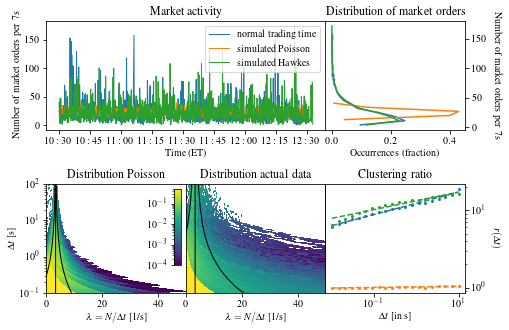

In [19]:
ats_array = [('normal trading time',real_data),  ('simulated Poisson',poisson_array), ('simulated Hawkes',sim)]

tau = np.logspace(-2,1,20)
N=1000
stepsize_hist=7.


if len(ats_array) > 20:
        ats_array = [ats_array]

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7.5,5)
fig = plt.figure()
grid = plt.GridSpec(2, 3, wspace=0.0, hspace=.5)

for kts_array in ats_array:
    if type(kts_array) is tuple:
        ts_array = kts_array[1]
        label = kts_array[0]
    else:
        ts_array = kts_array

    ax = plt.subplot(grid[0, 0:2])
    ax.set_xlabel('Time (ET)')
    x_bins, y_bins, _ = al.dobins(ts_array, N = N)
    
    
    plt.plot(salib.to_date(data_param['start']+1000*x_bins), y_bins, label=label, lw=1)
    ddt = x_bins[1]-x_bins[0]
    plt.title('Market activity')
    plt.ylabel('Number of market orders per {:.0f}s'.format( ddt))
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.legend()
    
    
    ax2 = plt.subplot(grid[0, 2])
    plt.ylabel('Number of market orders per {:.0f}s'.format( ddt), rotation=270)
    plt.xlabel('Occurrences (fraction)')
    

    a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
    plt.title('Distribution of market orders')
    plt.plot(b_bins/b_bins.sum(), a_bins, label=label)


    print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())
    
    ax2.yaxis.tick_right()
    ax2.yaxis.labelpad = 15
    ax2.yaxis.set_label_position("right")
    
    
    ax2 = plt.subplot(grid[1, 2])


    x,y,r = calc_r_tau(ts_array, tau)
    
    
    f = lambda tau,beta,A: A/(tau**beta)
    fitted = scipy.optimize.curve_fit(f, tau,r)
    plt.title('Clustering ratio')
    p = plt.loglog(tau,r , label=label, marker='.', ls='', markersize=4)
    plt.loglog(tau,f(tau, fitted[0][0], fitted[0][1]),ls='--', c=p[0].get_color(),label=label+' fitted' )

    plt.xlabel(r'$\Delta t$ [in s]')
    plt.ylabel(r'$r(\Delta t)$', rotation=270)
    ax2.yaxis.tick_right()
    ax2.yaxis.labelpad = 15
    ax2.yaxis.set_label_position("right")
    
    

for idx,dist,lab in zip([0,1],[pdist, rddist],['Poisson','actual data']):
    ax = plt.subplot(grid[1, idx])
    Z = dist['tdgraph']
    im = plt.pcolor(dist['a_bins'], dist['stepsize'], Z,
                       norm=colors.LogNorm(vmin=1e-4, vmax=5e-1))
    
    if idx == 0:
        
        
        plt.ylabel(r'$\Delta t$ [s]')
    else:
        ax.get_yaxis().set_visible(False)
        
    plt.plot(dist['meanl'],  dist['stepsize'],c='k',lw=1)
    plt.plot(dist['meanl']+dist['stdl'],  dist['stepsize'],c='k',lw=1)
    plt.plot(dist['meanl']-dist['stdl'],  dist['stepsize'],c='k',lw=1)
    
    plt.yscale('log')
    
    plt.title('Distribution '+lab)
    plt.xlabel(r'$\lambda = N/\Delta t$ [1/s]')
    
    plt.xlim([0, 50])
    #im.set_
    
    if idx == 0:
        cbaxes = inset_axes(ax, width="5%", height="70%", loc=1) 

        plt.colorbar(im, cax=cbaxes)
        cbaxes.yaxis.set_ticks_position('left')


fig.savefig(folder+"res_lob50.pdf")


In [20]:
salib.tic()
# Load all Graphs
sa_array = []
for i in pg.get_kn_entries({'selected':1}):
    print('load',i['id'])
    sa_array.append({'kn':i,'sa':salib.stock_analytics(i['id'], gui_mode=False)})
sa = sa_array[0]['sa']
salib.toc()

load 20190910_AAPL
redis 192.168.0.94
load 20190325_AAPL
redis 192.168.0.94
load 20181030_AAPL
redis 192.168.0.94
load 20180912_AAPL
redis 192.168.0.94
load 20180604_AAPL
redis 192.168.0.94
load 20180327_AAPL
redis 192.168.0.94
load 20170912_AAPL
redis 192.168.0.94
load 20170605_AAPL
redis 192.168.0.94
load 20161027_AAPL
redis 192.168.0.94
load 20160907_AAPL
redis 192.168.0.94
load 20160613_AAPL
redis 192.168.0.94
load 20160321_AAPL
redis 192.168.0.94
load 20150909_AAPL
redis 192.168.0.94
load 20150608_AAPL
redis 192.168.0.94
load 20150309_AAPL
redis 192.168.0.94
Elapsed time: 0.04466854897327721s


redis 192.168.0.94
V = 2592.121196 ; E = 54.798 ; V/E = 47.303208073287344
V = 635.768 ; E = 54.8 ; V/E = 11.60160583941606


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

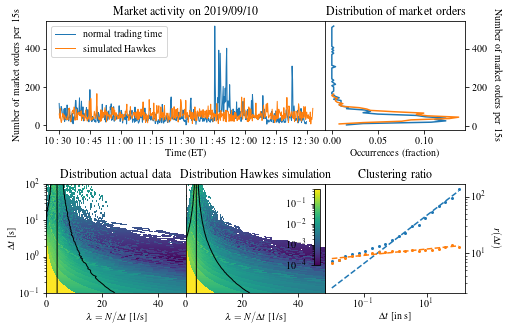

redis 192.168.0.94
V = 499.71159600000004 ; E = 34.398 ; V/E = 14.527344496773068
V = 146.57959599999998 ; E = 34.398 ; V/E = 4.261282516425372


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

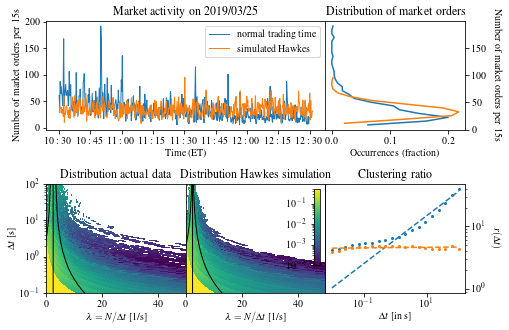

redis 192.168.0.94
V = 958.9363359999999 ; E = 47.108 ; V/E = 20.35612498938609
V = 788.0643359999999 ; E = 47.108 ; V/E = 16.72888545469984


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

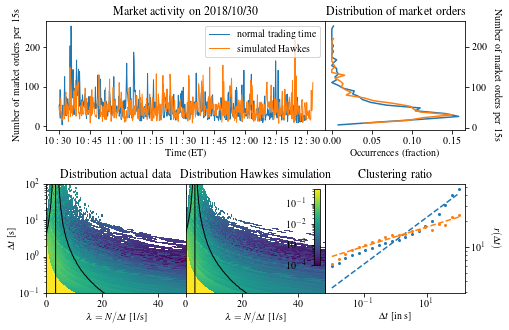

redis 192.168.0.94
V = 4351.5515000000005 ; E = 75.15 ; V/E = 57.90487691284099
V = 1288.5195 ; E = 75.15 ; V/E = 17.145968063872257


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

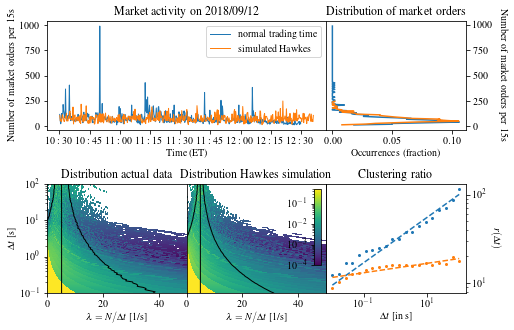

redis 192.168.0.94
V = 547.747404 ; E = 21.314 ; V/E = 25.698949235244438
V = 178.47214400000001 ; E = 21.316 ; V/E = 8.372684556201914


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

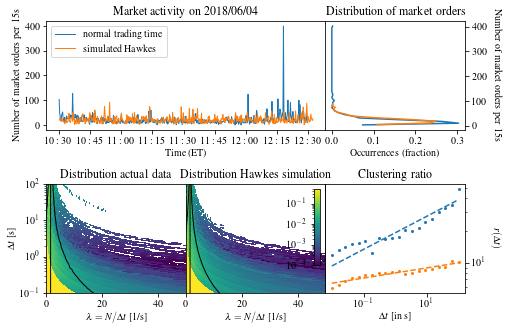

redis 192.168.0.94
V = 441.248076 ; E = 29.882 ; V/E = 14.7663501773643
V = 278.82007600000003 ; E = 29.882 ; V/E = 9.330703299645272


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

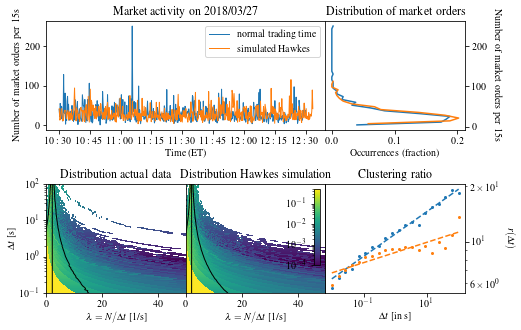

redis 192.168.0.94
V = 568.8344000000001 ; E = 27.24 ; V/E = 20.882320117474308
V = 247.91143599999998 ; E = 27.242 ; V/E = 9.100339035313118


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

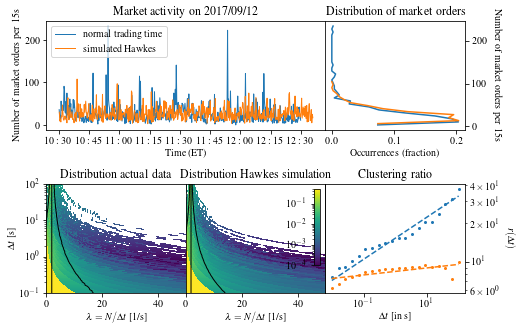

redis 192.168.0.94
V = 182.36550399999996 ; E = 18.864 ; V/E = 9.667382527565731
V = 153.617504 ; E = 18.864 ; V/E = 8.143421543681086


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

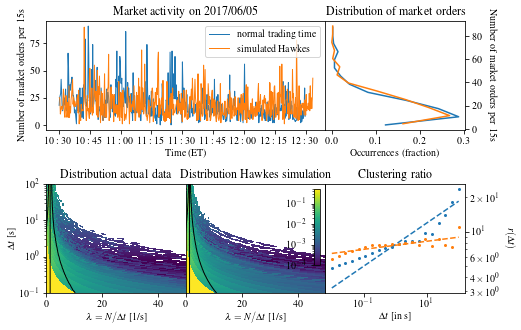

redis 192.168.0.94
V = 201.38109999999998 ; E = 17.67 ; V/E = 11.396779852857948
V = 170.76041600000002 ; E = 17.672 ; V/E = 9.662766862833863


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

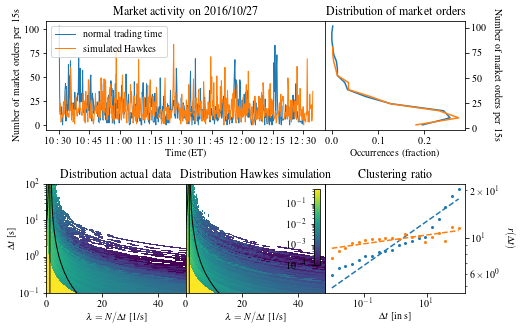

redis 192.168.0.94
V = 273.3864 ; E = 16.36 ; V/E = 16.710660146699265
V = 212.01839999999996 ; E = 16.36 ; V/E = 12.959559902200487


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

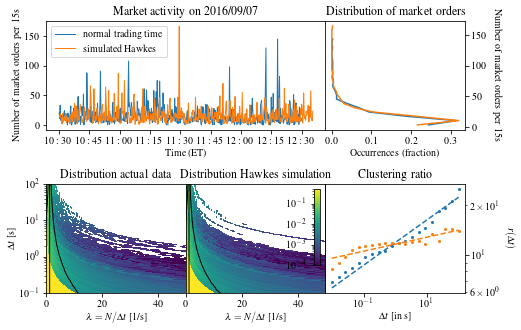

redis 192.168.0.94
V = 413.59582400000005 ; E = 26.276 ; V/E = 15.740440858578172
V = 336.031824 ; E = 26.276 ; V/E = 12.788545592936519


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

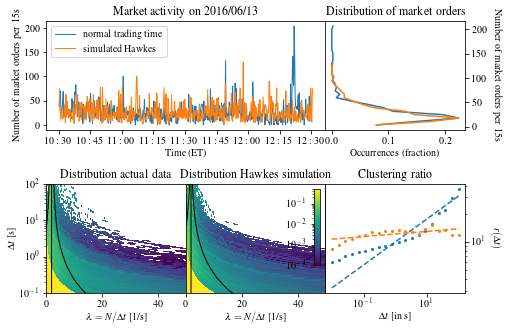

redis 192.168.0.94
V = 194.675244 ; E = 16.234 ; V/E = 11.991822348158184
V = 129.876304 ; E = 16.236 ; V/E = 7.999279625523528


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

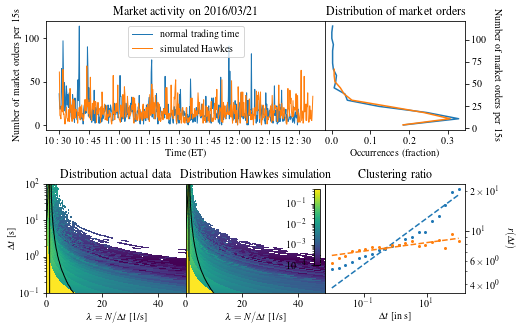

redis 192.168.0.94
V = 374.260736 ; E = 26.208 ; V/E = 14.28040048840049
V = 193.19070441950427 ; E = 26.157684630738522 ; V/E = 7.38561945167277


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

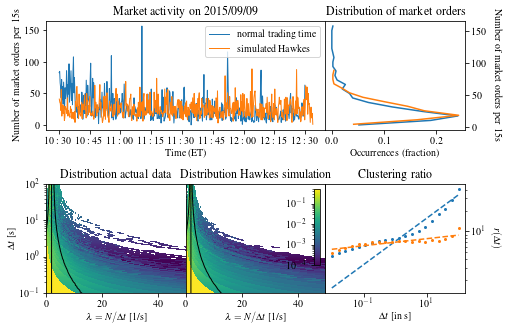

redis 192.168.0.94
V = 943.9003960000002 ; E = 23.902 ; V/E = 39.490435779432694
V = 304.00329879163826 ; E = 23.856287425149702 ; V/E = 12.743110165211743


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

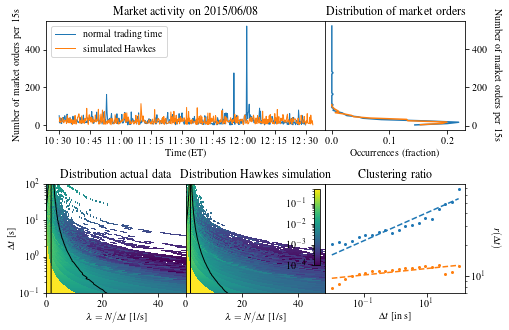

redis 192.168.0.94
V = 496.34849600000007 ; E = 29.748 ; V/E = 16.685104746537583
V = 231.2675 ; E = 29.75 ; V/E = 7.773697478991597


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

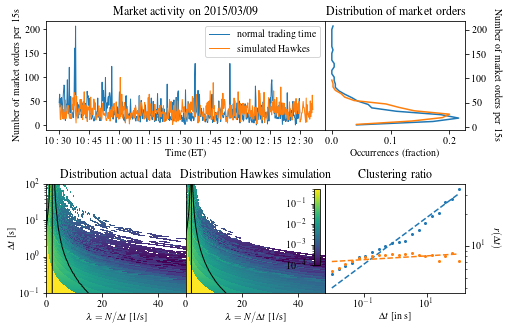

In [21]:
for knid in [k['kn']['id'] for k in sa_array]:

    data_param = {
    'id':knid,
    'start':10.5*3600*1000,
    'stop':12.5*3600*1000
    }
    real_data = fl.load_data(data_param)
    
    # Load Hawkes Simulation
    tbl = tl.dbconnect()
    tasks = list(
            tbl.aggregate([{"$match":{"status":3,"task.id":knid}},{"$sort":{"task.id":1}}])
        )
    findtask = [t for t in tasks if t['task']['task'] == 'fit' and t['task']['method'] == 'mle' and t['task']['name'] == 'fit_corrected_fixed']
    mleid = findtask[0]['_id']
    sim = [t for t in tasks if t['task']['task'] == 'simulate' and t['task']['origin']['id'] == mleid][0]['result']['sim_results']

    rddist = calculate_distributions(real_data,stepsize = np.logspace(-1,2,100),a_bins_in= np.linspace(0,100,20))
    simdist = calculate_distributions(sim,stepsize = np.logspace(-1,2,100),a_bins_in= np.linspace(0,100,20))
    
    


    ats_array = [('normal trading time',real_data), ('simulated Hawkes',sim)]

    tau = np.logspace(-2,2,20)
    N=500
    stepsize_hist=7.


    if len(ats_array) > 20:
            ats_array = [ats_array]

    rc('font',**{'family':'serif','serif':['Times']})
    rc('text', usetex=True)
    plt.rcParams["figure.figsize"] = (7.5,5)
    fig = plt.figure()
    grid = plt.GridSpec(2, 3, wspace=0.0, hspace=.5)

    for kts_array in ats_array:
        if type(kts_array) is tuple:
            ts_array = kts_array[1]
            label = kts_array[0]
        else:
            ts_array = kts_array

        ax = plt.subplot(grid[0, 0:2])
        ax.set_xlabel('Time (ET)')
        x_bins, y_bins, _ = al.dobins(ts_array, N = N)


        plt.plot(salib.to_date(data_param['start']+1000*x_bins), y_bins, label=label, lw=1)
        ddt = x_bins[1]-x_bins[0]
        plt.title('Market activity on '+knid[:4]+'/'+knid[4:6]+'/'+knid[6:8])
        plt.ylabel('Number of market orders per {:.0f}s'.format( ddt))
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)

        plt.legend()


        ax2 = plt.subplot(grid[0, 2])
        plt.ylabel('Number of market orders per {:.0f}s'.format( ddt), rotation=270)
        plt.xlabel('Occurrences (fraction)')


        a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
        plt.title('Distribution of market orders')
        plt.plot(b_bins/b_bins.sum(), a_bins, label=label)


        print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())

        ax2.yaxis.tick_right()
        ax2.yaxis.labelpad = 15
        ax2.yaxis.set_label_position("right")


        ax2 = plt.subplot(grid[1, 2])


        x,y,r = calc_r_tau(ts_array, tau)


        f = lambda tau,beta,A: A/(tau**beta)
        fitted = scipy.optimize.curve_fit(f, tau,r)
        plt.title('Clustering ratio')
        p = plt.loglog(tau,r , label=label, marker='.', ls='', markersize=4)
        plt.loglog(tau,f(tau, fitted[0][0], fitted[0][1]),ls='--', c=p[0].get_color(),label=label+' fitted' )

        plt.xlabel(r'$\Delta t$ [in s]')
        plt.ylabel(r'$r(\Delta t)$', rotation=270)
        ax2.yaxis.tick_right()
        ax2.yaxis.labelpad = 15
        ax2.yaxis.set_label_position("right")



    for idx,dist,lab in zip([0,1],[rddist, simdist],['actual data','Hawkes simulation']):
        ax = plt.subplot(grid[1, idx])
        Z = dist['tdgraph']
        im = plt.pcolor(dist['a_bins'], dist['stepsize'], Z,
                           norm=colors.LogNorm(vmin=1e-4, vmax=5e-1))

        if idx == 0:


            plt.ylabel(r'$\Delta t$ [s]')
        else:
            ax.get_yaxis().set_visible(False)


        plt.plot(dist['meanl'],  dist['stepsize'],c='k',lw=1)
        plt.plot(dist['meanl']+dist['stdl'],  dist['stepsize'],c='k',lw=1)
        plt.plot(dist['meanl']-dist['stdl'],  dist['stepsize'],c='k',lw=1)

        plt.yscale('log')

        plt.title('Distribution '+lab)
        plt.xlabel(r'$\lambda = N/\Delta t$ [1/s]')


        plt.xlim([0, 50])


        if idx == 1:
            cbaxes = inset_axes(ax, width="5%", height="70%", loc=1) 

            plt.colorbar(im, cax=cbaxes)
            cbaxes.yaxis.set_ticks_position('left')

    plt.show()


    #plt.tight_layout()
    fig.savefig(folder+"res_lob_normal_"+knid+".pdf")


In [23]:
for knid in [k['kn']['id'] for k in sa_array]:
    date = knid[:4]+'/'+knid[4:6]+'/'+knid[6:8]
    data_param = {
    'id':knid,
    'start':10.5*3600*1000,
    'stop':12.5*3600*1000
    }
    with redirect_stdout(None):
        real_data = fl.load_data(data_param)
    
    # Load Hawkes Simulation
    tbl = tl.dbconnect()
    tasks = list(
            tbl.aggregate([{"$match":{"status":3,"task.id":knid}},{"$sort":{"task.id":1}}])
        )
    findtask = [t for t in tasks if t['task']['task'] == 'fit' and t['task']['method'] == 'mle' and t['task']['name'] == 'fit_corrected_fixed']
    g_param = findtask[0]['result']['g_params']
    l0 = (1-g_param[0])*len(real_data)/real_data[-1]
    print(r"""\begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob_normal_"""+knid+""".pdf}
    \caption{Comparison of market activity between simulation and empirical data on """+
          date+
          r" for normal trading time. Simulation parameters are $\lambda_0 = {:.2f}, g = {:.2f}, \omega  = {:.0f}, \beta  = {:.2f}".format(l0,*g_param)+
          r"""$}
\end{figure}

""")

\begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob_normal_20190910_AAPL.pdf}
    \caption{Comparison of market activity between simulation and empirical data on 2019/09/10 for normal trading time. Simulation parameters are $\lambda_0 = 1.09, g = 0.71, \omega  = 4261, \beta  = 0.59$}
\end{figure}


\begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob_normal_20190325_AAPL.pdf}
    \caption{Comparison of market activity between simulation and empirical data on 2019/03/25 for normal trading time. Simulation parameters are $\lambda_0 = 1.02, g = 0.57, \omega  = 3296, \beta  = 0.65$}
\end{figure}


\begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob_normal_20181030_AAPL.pdf}
    \caption{Comparison of market activity between simulation and empirical data on 2018/10/30 for normal trading time. Simulation param

In [25]:
def integral_over_phi(t,deltat, omegak, a, K, phi_0,g):
   
    summand = np.sum((1-np.exp(-np.outer(omegak,deltat))).T * np.sum(np.multiply(np.exp(-np.outer(omegak,(t[-1]-t))).T,a), axis=0)  ,axis=1) \
        if len(t) > 0 else 0
    return deltat*phi_0 + g*summand
            
def probability_for_inter_arrival_time(t, deltat, omegak, a, K, phi_0,g):

    x= integral_over_phi(t,deltat, omegak, a, K, phi_0,g)
    return 1-np.exp(-x)

In [26]:
# Show probability distribution!

tg, tg_omega, tg_beta = (0.89, 0.430042, 0.253835)
tK = 15
tphi_0 = 0
tomegak, ta = al.generate_series_parameters(tg_omega, tg_beta, K=tK, b=5.)


thawkes_array = np.zeros(10)
thawkes_array[0] = 0
ti = 1
tj = 0


tau_x = np.logspace(-3,10,1000)
pt = probability_for_inter_arrival_time(thawkes_array[tj:ti],tau_x,  tomegak, ta, tK, tphi_0, tg)



In [28]:
with open('eff_g_sim.json','r') as f:
    eff_g_sim = json.load(  f)

In [29]:
gg = 0.89

In [30]:
mapkv = {
    'noe_thin_cache_K15':'By thinning w/ cache (K = 15)',
    'noe_thin_no_cache_K15':'By thinning (K = 15)',
    'noe_thin_cache_K0':'By thinning w/ cache (K = 1)',
    'noe_thin_no_cache_K0':'By thinning (K = 1)',
    'noe_itrans_binary_K15':'By inverse transform (K = 15)',
    'noe_itrans_no_binary_K15':'By inverse transform w/ simple algo (K = 15)',
    'noe_itrans_binary_K0':'By inverse transform (K = 1)',
    'noe_itrans_no_binary_K0':'By inverse transform w/ simple algo (K = 1)',
    
}

In [32]:
def calc_eff_g(ax, number_of_events, g, label=''):
    noe_binned_x, noe_binned_y, _ = al.dobins(number_of_events, useinteger=True, N=1000) 
    noe_binned_y /= noe_binned_y.sum()
    assert np.abs(np.sum(noe_binned_y) - 1) < 1e-8

    print((noe_binned_x*noe_binned_y).sum(), 'should be', 1/(1-g))
    print(noe_binned_y[0])
    ax.semilogx(noe_binned_x,noe_binned_y,'.', markersize=2, label=label+' N = {:.1f}'.format((noe_binned_x*noe_binned_y).sum())
           )

9.226672667266726 should be 9.090909090909092
0.4158415841584158
8.993249324932494 should be 9.090909090909092
0.42024202420242024
7.871937193719372 should be 9.090909090909092
0.4231423142314231
8.96779355871174 should be 9.090909090909092
0.41278255651130225


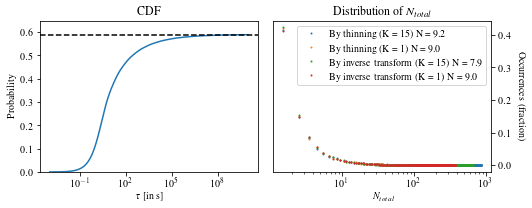

In [35]:
graph_pre()
fig, axs = plt.subplots(1,2)
for k,v in eff_g_sim.items():
    if not 'thin_no_cache' in k and 'itrans_binary' not in k:
        continue
    calc_eff_g(axs[1], v, gg, mapkv[k])
plt.legend()
ax = axs[0]
ax.set_title('CDF')
ax.set_ylabel('Probability')
ax.set_xlabel(r'$\tau$ [in s]')
ax.semilogx(tau_x,pt,'-')
ax.axhline(y=1-np.exp(-gg), color="black", linestyle="--")
ax.set_ylim([0,0.65])

ax2 = axs[1]
ax2.set_title(r'Distribution of $N_{total}$')
ax2.set_ylabel('Occurrences (fraction)',rotation=270)
ax2.set_xlabel('$N_{total}$')
ax2.yaxis.tick_right()
ax2.yaxis.labelpad = 15
ax2.yaxis.set_label_position("right")

graph_post()
fig.savefig(folder+"res_lob51.pdf")

In [36]:
with open('17_simulation.json', 'r') as f:
    simulation_res = json.load(f)

In [37]:
simulation_res = [(a,np.array(b)) for a,b in simulation_res]

In [38]:
mapname = {
    'sim_thin_no_cache':'By thinning',
    'sim_itrans_binary':'By inv. transform (w/ binary)',
    'sim_itrans_nobinary':'By inv. transform (w/ simple method)'
}

In [39]:
simulation_res2 = []
for k,v in simulation_res:
    simulation_res2.append((mapname[k],v))


V = 74.29264577653669 ; E = 33.222591362126245 ; V/E = 2.2362086378737542
V = 73.83417401573934 ; E = 33.222591362126245 ; V/E = 2.222408637873754
V = 76.12110000000001 ; E = 33.33 ; V/E = 2.2838613861386143


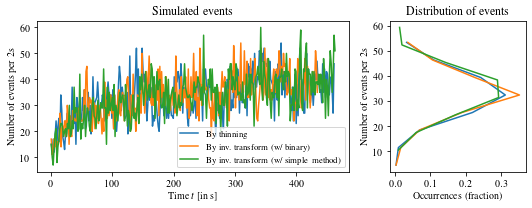

In [40]:
ats_array = simulation_res2

tau = np.logspace(-2,1.5,20)
N=300
stepsize_hist=7.


if len(ats_array) > 20:
        ats_array = [ats_array]

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7.5,3)
fig = plt.figure()
grid = plt.GridSpec(1, 3)

for kts_array in ats_array:
    if type(kts_array) is tuple:
        ts_array = kts_array[1]
        label = kts_array[0]
    else:
        ts_array = kts_array

    ax = plt.subplot(grid[0, 0:2])
    x_bins, y_bins, _ = al.dobins(ts_array, N = N)
    
    
    plt.plot(x_bins[:-1], y_bins[:-1], label=label)
    ddt = x_bins[1]-x_bins[0]
    plt.title('Simulated events')
    plt.ylabel('Number of events per {:.0f}s'.format( ddt))
    plt.xlabel('Time $t$ [in s]')
    
    plt.legend(fontsize=9)
    plt.subplot(grid[0, 2])
    plt.ylabel('Number of events per {:.0f}s'.format( ddt))
    plt.xlabel('Occurrences (fraction)')
    

    a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
    plt.title('Distribution of events')
    plt.plot(b_bins/b_bins.sum(), a_bins, label=label)


    print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())
    
plt.tight_layout()
fig.savefig(folder+"res_lob52.pdf")


In [45]:
knid = '20160321_AAPL'

In [46]:
tbl = tl.dbconnect('tasks_old', reset=True)

fitted c_params powerfit [3.1802754414748504, 306.87914145923787, 0.14285424663817708]
fitted c_params lsqfit   [0.9136599451520626, 47.4439004110442, 31.569924592895802]


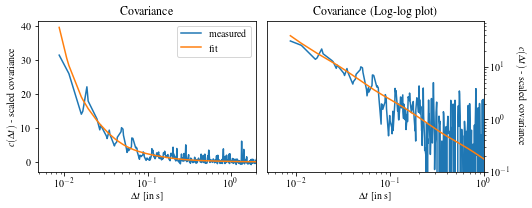

In [47]:
graph_pre()

all_results = {}
 
q = [{"$match":{"status":3,"task.id":knid,'task.method':'moments'}},{"$sort":{"task.task":1,"task.method":1}}]
  
tasks = list(
        tbl.aggregate(q  ))


    
fig, axs = plt.subplots(1,2)

# Have a look of print statements
for i in tasks:
    cov = i['result']['cov_different_dt']
    cov_x = np.array(i['result']['cov_x'])
    cov_y = np.array(i['result']['cov_y'])
    if 'powerfit' in i['result']['cov_fit']:
        fitted_power = i['result']['cov_fit']['powerfit']['c_param']
        print('fitted c_params powerfit',fitted_power)
    
    if 'lsqfit' in i['result']['cov_fit']:
        fitted_lsqfit = i['result']['cov_fit']['lsqfit']['c_param']
        print('fitted c_params lsqfit  ',fitted_lsqfit)


pf_g, pf_omega, pf_beta = fitted_power
f_power = lambda x,g,omega,beta: g*omega*beta/((1+omega*x)**(1+beta))


axs[1].loglog(cov_x, cov_y, label='measured covariance')
axs[1].loglog(cov_x, al.c_exp_series_wrap(cov_x, pf_g, pf_omega, pf_beta), label='fit')

axs[1].set_xlim([None, 1])
axs[1].set_ylim([1e-1,None])
axs[1].set_xlabel(r'$\Delta t$ [in s]')
axs[0].set_xlabel(r'$\Delta t$ [in s]')
axs[0].set_ylabel(r'$c(\Delta t)$ - scaled covariance')
axs[1].set_ylabel(r'$c(\Delta t)$ - scaled covariance',rotation=270)
axs[0].set_title('Covariance')
axs[1].set_title('Covariance (Log-log plot)')

axs[1].yaxis.tick_right()
axs[1].yaxis.labelpad = 15
axs[1].yaxis.set_label_position("right") 

axs[0].semilogx(cov_x, cov_y, label='measured')
axs[0].semilogx(cov_x, al.c_exp_series_wrap(cov_x, pf_g, pf_omega, pf_beta), label='fit')
axs[0].legend()
axs[0].set_xlim([None, 2])
graph_post()

fig.savefig(folder+"res_lob54.pdf")

In [72]:
tbl = tl.dbconnect(reset=True)
tasks = list(
        tbl.aggregate([{"$match":{'status': 3, 'error': None, 'task.origin.task.origin.text': '$99', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20150309_AAPL'}},{"$sort":{"task.id":1}}])
    )

In [73]:
assert len(tasks) == 1

In [74]:
result_sim = tasks[0]["result"]

In [75]:
sim_results = np.array(result_sim['sim_results'])
task_sim = tasks[0]['task']

redis 192.168.0.94
(1) V = 832.1179 ; E = 27.11 ; V/E = 30.69413131685725
(2) V = 3652.13 ; E = 53.9 ; V/E = 67.75751391465677
V = 2421.549975 ; E = 40.505 ; V/E = 59.783976669546966
(1) V = 336.94759999999997 ; E = 27.18 ; V/E = 12.39689477557027
(2) V = 1926.2211000000004 ; E = 53.83 ; V/E = 35.783412595207146
V = 1309.139975 ; E = 40.505 ; V/E = 32.32045364769782


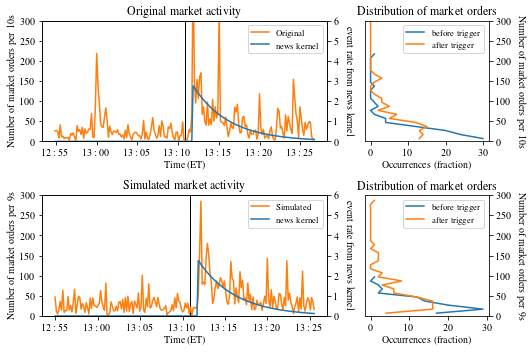

In [78]:
original_data = fl.load_data(task_sim)
sim_results_cutted = sim_results[sim_results <= original_data[-1]]

ats_array = [('Original',original_data), ('Simulated',sim_results_cutted)]

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7.5,5)

tau = np.logspace(-3,2,20)
N=200
splitpoint=None
stepsize_hist=2.

if len(ats_array) > 20:
    ats_array = [ats_array]


fig = plt.figure()
grid = plt.GridSpec(2, 3)

row = 0
for kts_array in ats_array:
    if type(kts_array) is tuple:
        ts_array = kts_array[1]
        label = kts_array[0]
    else:
        ts_array = kts_array
    
    
    ax = plt.subplot(grid[row, 0:2])
    midp = salib.to_date_i(tasks[0]['task']['origin']['task']['start']+1000*task_sim['origin']['task']['t_0'])
    plt.plot([midp, midp],[0,1000],c='k',lw=1)
    x_bins, y_bins, _ = al.dobins(ts_array, N = N)
    tx_bins = salib.to_date(tasks[0]['task']['origin']['task']['start']+1000*x_bins)
    lns1 =plt.plot(tx_bins, y_bins, label=label,c='tab:orange')
    
    ax.set_xlabel('Time (ET)')


    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ddt = x_bins[1]-x_bins[0]
    plt.title(label+' market activity')
    plt.ylabel('Number of market orders per {:.0f}s'.format( ddt))
    
    x_bins_news = x_bins[x_bins > task_sim['news_params'][0][0]]
    y_bins_news_frac = task_sim['news_params'][0][1]*np.exp(-task_sim['news_params'][0][2]*(x_bins_news-task_sim['news_params'][0][0]))
    y_bins_news = np.zeros(len(x_bins))
    y_bins_news[x_bins > task_sim['news_params'][0][0]] =y_bins_news_frac
    
    ax3 = ax.twinx()
    
    myFmt = mdates.DateFormatter('%H:%M')
    ax3.xaxis.set_major_formatter(myFmt)
    
    
    lns2 = ax3.plot(tx_bins, y_bins_news,label='news kernel')
    lns = lns1+lns2
    plt.legend(lns,[l.get_label() for l in lns], fontsize=9)
    ax.set_ylim(0, 300)
    ax3.set_ylim(0, 6)
    ax3.yaxis.labelpad = 15
    ax3.set_ylabel('event rate from news kernel',rotation=270)
    ax2 = plt.subplot(grid[row, 2])
    plt.title('Distribution of market orders')
    plt.ylabel('Number of market orders per {:.0f}s'.format( ddt), rotation=270)
    ax2.yaxis.tick_right()
    ax2.yaxis.labelpad = 15
    ax2.yaxis.set_label_position("right")    
    plt.xlabel('Occurrences (fraction)')
    splitpoint = 0.5
    stepsize_hist= 10.
    if splitpoint is not None:
        y_bins1 = y_bins[:int(splitpoint*len(y_bins))]
        y_bins2 = y_bins[int(splitpoint*len(y_bins)):]
        a_bins1, b_bins1, _ = al.dobins(y_bins1, useinteger=True, stepsize=stepsize_hist)
        a_bins2, b_bins2, _ = al.dobins(y_bins2, useinteger=True, stepsize=stepsize_hist)
        plt.plot(b_bins1, a_bins1, label='before trigger')
        plt.plot(b_bins2, a_bins2, label='after trigger')
        plt.legend(fontsize=9)
        print('(1) V =',y_bins1.var(),'; E =',y_bins1.mean(),'; V/E =', y_bins1.var()/y_bins1.mean())
        print('(2) V =',y_bins2.var(),'; E =',y_bins2.mean(),'; V/E =', y_bins2.var()/y_bins2.mean())
    else:
        a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
        plt.plot(b_bins, a_bins, label=label)
    plt.ylim(0, 300)

    print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())

    row+=1
plt.tight_layout()
fig.savefig(folder+"res_lob55.pdf")

In [158]:
tbl = tl.dbconnect()
tasks = list(
        tbl.aggregate([{"$match":{"status":3,"error":None,'task.task':'simulate','task.origin.task.method':'mle_extended'}},{"$sort":{"task.id":1}}])
    )

In [159]:
results = {}

for t in tasks:
    t0 = t['task']['origin']['task']['t_0']
    assert t0 == 960.       
        
    results[key] = {
        'g_params':t['task']['g_params'],
        'news_params':t['task']['news_params'],
        'task':t,
         'filter':{"status":3,"error":None,
                              "task.origin.task.origin.text":t['task']['origin']['task']['origin']['text'],
                              "task.origin.task.origin.src":t['task']['origin']['task']['origin']['src'],
                              "task.id":t['task']['id'],
                             }
    }

        

$799 {"GLEICHER FRAME": {"10": ""}, "News": {"10": "NEU"}, "Produkt": {"10": "iPhone 8 Plus"}, "knid": {"10": 0}, "price": {"10": "799"}, "triggerid": {"10": 9.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$799', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20170912_AAPL'}
redis 192.168.0.94
(1) V = 1825.6344 ; E = 63.84 ; V/E = 28.597030075187966
(2) V = 7412.661899999999 ; E = 135.41 ; V/E = 54.742352115796464
V = 5899.714375 ; E = 99.625 ; V/E = 59.21921580928481
(1) V = 816.63 ; E = 59.3 ; V/E = 13.77116357504216
(2) V = 2499.43 ; E = 113.5 ; V/E = 22.021409691629955
V = 2392.44 ; E = 86.4 ; V/E = 27.690277777777776


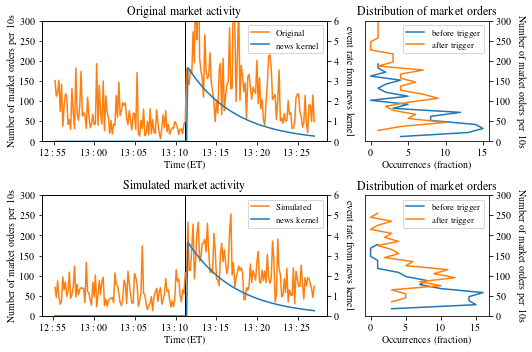

$999 {"GLEICHER FRAME": {"51": ""}, "News": {"51": "NEU"}, "Produkt": {"51": "iPhone 11 Pro"}, "knid": {"51": 3}, "price": {"51": "999"}, "triggerid": {"51": 10.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$999', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 831.13 ; E = 39.3 ; V/E = 21.148346055979644
(2) V = 5552.8756 ; E = 92.62 ; V/E = 59.95331030015116
V = 3902.7584 ; E = 65.96 ; V/E = 59.168562765312316
(1) V = 484.0339 ; E = 40.31 ; V/E = 12.007787149590673
(2) V = 845.8300000000002 ; E = 68.1 ; V/E = 12.420411160058741
V = 858.0029749999999 ; E = 54.205 ; V/E = 15.828852965593578


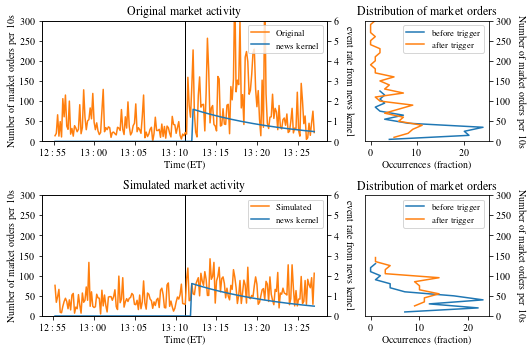

iPad mini nan
{'status': 3, 'error': None, 'task.origin.task.origin.text': 'iPad mini', 'task.origin.task.origin.src': 'keyword_subs', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 1620.0796000000003 ; E = 48.98 ; V/E = 33.076349530420586
(2) V = 10584.4379 ; E = 115.11 ; V/E = 91.95063765094258
V = 7195.552975000001 ; E = 82.045 ; V/E = 87.70251660674022
(1) V = 771.1384000000002 ; E = 48.04 ; V/E = 16.05200666111574
(2) V = 2677.43750612685 ; E = 94.47524752475248 ; V/E = 28.34009517069921
V = 2268.0747011212593 ; E = 71.3731343283582 ; V/E = 31.77770911232212


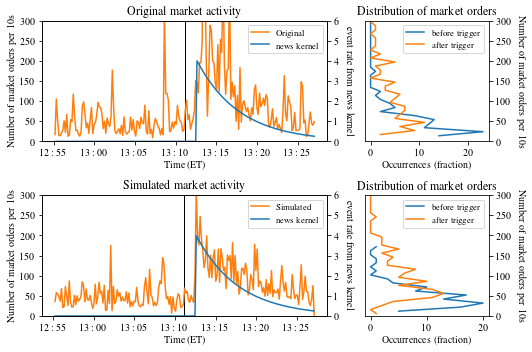

$449 {"GLEICHER FRAME": {"47": ""}, "News": {"47": "alt"}, "Produkt": {"47": "iPhone 8"}, "knid": {"47": 3}, "price": {"47": "449"}, "triggerid": {"47": 6.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$449', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 1017.7476000000003 ; E = 40.82 ; V/E = 24.932572268495843
(2) V = 5381.520399999999 ; E = 90.86 ; V/E = 59.22870790226722
V = 3825.6343999999995 ; E = 65.84 ; V/E = 58.10501822600242
(1) V = 553.7824 ; E = 39.76 ; V/E = 13.928128772635818
(2) V = 811.6044000000002 ; E = 72.34 ; V/E = 11.219303290019354
V = 948.0575 ; E = 56.05 ; V/E = 16.91449598572703


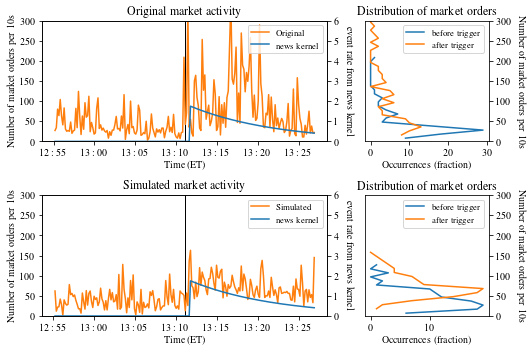

$699 {"GLEICHER FRAME": {"50": ""}, "News": {"50": "NEU"}, "Produkt": {"50": "iPhone 11"}, "knid": {"50": 3}, "price": {"50": "699"}, "triggerid": {"50": 9.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$699', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 1388.4419 ; E = 60.91 ; V/E = 22.79497455261862
(2) V = 9923.4944 ; E = 88.84 ; V/E = 111.70074741107608
V = 5850.989375 ; E = 74.875 ; V/E = 78.14343071786311
(1) V = 803.2984000000001 ; E = 54.04 ; V/E = 14.864885270170246
(2) V = 2405.1139000000003 ; E = 75.19 ; V/E = 31.987151216917148
V = 1716.0367749999998 ; E = 64.615 ; V/E = 26.5578700766076


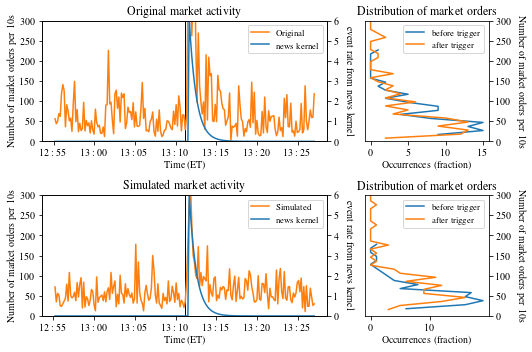

In [160]:
figid = 0
for k,v in results.items():
    print(k)
    print(v['filter'])
    result_sim = v['task']["result"]
    sim_results = np.array(result_sim['sim_results'])
    task_sim = v['task']['task']
    


    original_data = fl.load_data(task_sim)
    sim_results_cutted = sim_results[sim_results <= original_data[-1]]

    ats_array = [('Original',original_data), ('Simulated',sim_results_cutted)]

    rc('font',**{'family':'serif','serif':['Times']})
    rc('text', usetex=True)
    plt.rcParams["figure.figsize"] = (7.5,5)

    tau = np.logspace(-3,2,20)
    N=200
    splitpoint=None
    stepsize_hist=2.

    if len(ats_array) > 20:
        ats_array = [ats_array]


    fig = plt.figure()
    grid = plt.GridSpec(2, 3)

    row = 0
    for kts_array in ats_array:
        if type(kts_array) is tuple:
            ts_array = kts_array[1]
            label = kts_array[0]
        else:
            ts_array = kts_array


        ax = plt.subplot(grid[row, 0:2])
        midp = salib.to_date_i(tasks[0]['task']['origin']['task']['start']+1000*task_sim['origin']['task']['t_0'])
        plt.plot([midp, midp],[0,1000],c='k',lw=1)
        x_bins, y_bins, _ = al.dobins(ts_array, N = N)
        tx_bins = salib.to_date(tasks[0]['task']['origin']['task']['start']+1000*x_bins)
        lns1 =plt.plot(tx_bins, y_bins, label=label,c='tab:orange')

        ax.set_xlabel('Time (ET)')


        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)
        ddt = x_bins[1]-x_bins[0]
        plt.title(label+' market activity')
        plt.ylabel('Number of market orders per {:.0f}s'.format( ddt))

        x_bins_news = x_bins[x_bins > task_sim['news_params'][0][0]]
        y_bins_news_frac = task_sim['news_params'][0][1]*np.exp(-task_sim['news_params'][0][2]*(x_bins_news-task_sim['news_params'][0][0]))
        y_bins_news = np.zeros(len(x_bins))
        y_bins_news[x_bins > task_sim['news_params'][0][0]] =y_bins_news_frac

        ax3 = ax.twinx()

        myFmt = mdates.DateFormatter('%H:%M')
        ax3.xaxis.set_major_formatter(myFmt)


        lns2 = ax3.plot(tx_bins, y_bins_news,label='news kernel')
        lns = lns1+lns2
        plt.legend(lns,[l.get_label() for l in lns], fontsize=9)
        ax.set_ylim(0, 300)
        ax3.set_ylim(0, 6)
        ax3.yaxis.labelpad = 15
        ax3.set_ylabel('event rate from news kernel',rotation=270)
        ax2 = plt.subplot(grid[row, 2])
        plt.title('Distribution of market orders')
        plt.ylabel('Number of market orders per {:.0f}s'.format( ddt), rotation=270)
        ax2.yaxis.tick_right()
        ax2.yaxis.labelpad = 15
        ax2.yaxis.set_label_position("right")    
        plt.xlabel('Occurrences (fraction)')
        splitpoint = 0.5
        stepsize_hist= 10.
        if splitpoint is not None:
            y_bins1 = y_bins[:int(splitpoint*len(y_bins))]
            y_bins2 = y_bins[int(splitpoint*len(y_bins)):]
            a_bins1, b_bins1, _ = al.dobins(y_bins1, useinteger=True, stepsize=stepsize_hist)
            a_bins2, b_bins2, _ = al.dobins(y_bins2, useinteger=True, stepsize=stepsize_hist)
            plt.plot(b_bins1, a_bins1, label='before trigger')
            plt.plot(b_bins2, a_bins2, label='after trigger')
            plt.legend(fontsize=9)
            print('(1) V =',y_bins1.var(),'; E =',y_bins1.mean(),'; V/E =', y_bins1.var()/y_bins1.mean())
            print('(2) V =',y_bins2.var(),'; E =',y_bins2.mean(),'; V/E =', y_bins2.var()/y_bins2.mean())
        else:
            a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
            plt.plot(b_bins, a_bins, label=label)
        plt.ylim(0, 300)

        print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())

        row+=1
    plt.tight_layout()
    fig.savefig(folder+"res_lob55_appd"+str(figid)+".pdf")
    figid+=1
    plt.show()

In [182]:
figid = 0
for k,v in results.items():
    result_sim = v['task']["result"]
    sim_results = np.array(result_sim['sim_results'])
    task_sim = copy.deepcopy(v['task']['task'])
    task_sim['g_params'][1] = round(task_sim['g_params'][1]/100)*100
    task_sim['news_params'][0][0] -= 960
    knid = v['task']['task']['id']
    date = knid[:4]+'/'+knid[4:6]+'/'+knid[6:8]
    
    produkt = 'iPad mini' if k == 'iPad mini nan' else list(json.loads(k[k.find(' ')+1:])['Produkt'].values())[0]
    print(r"""
    \begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob55_appd"""+str(figid)+r""".pdf}
    \caption{Announcement of \textit{""" + produkt + r"} during " +date+r". Simulation with "+
          r"$g = {:.2f}, \omega= {:.0f}\frac{{1}}{{s}}, \beta={:.2f}, z - z^{{trigger}} =  {:.0f}s, \alpha={:.1f} \frac{{1}}{{s}}, \beta={:.4f}".format(
          *task_sim['g_params'], *task_sim['news_params'][0]) +
          r"""\frac{1}{s}$  }
\end{figure}
    
    """)
    figid += 1


    \begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob55_appd0.pdf}
    \caption{Announcement of \textit{iPhone 8 Plus} during 2017/09/12. Simulation with $g = 0.76, \omega= 3700\frac{1}{s}, \beta=0.54, z - z^{trigger} =  22s, \alpha=3.7 \frac{1}{s}, \beta=0.0028\frac{1}{s}$  }
\end{figure}
    
    

    \begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob55_appd1.pdf}
    \caption{Announcement of \textit{iPhone 11 Pro} during 2019/09/10. Simulation with $g = 0.72, \omega= 3900\frac{1}{s}, \beta=0.71, z - z^{trigger} =  53s, \alpha=1.6 \frac{1}{s}, \beta=0.0013\frac{1}{s}$  }
\end{figure}
    
    

    \begin{figure}[h!]
\centering
    \includegraphics[width=1.0\textwidth, trim=0 15 0 25]{generated_figures/res_lob55_appd2.pdf}
    \caption{Announcement of \textit{iPad mini} during 2019/09/10. Simulation with $g = 0.75, \omega= 4200\frac{1}{s}, \beta=0.61, z - z

In [57]:
plt.rcParams['figure.figsize'] = (15, 5)

In [58]:
tbl = tl.dbconnect(reset=True)
tasks = list(
        tbl.aggregate([{"$match":{"status":3,"error":None,"task.task":"simulate", 'task.origin.task.method':'mle',
                                 'task.origin.task.name':'fit_corrected_fixed'}},{"$sort":{"task.id":1}}])
    )
g_params = np.array([t['task']['g_params'] for t in tasks])

90
30 30 30
90
30 30 30


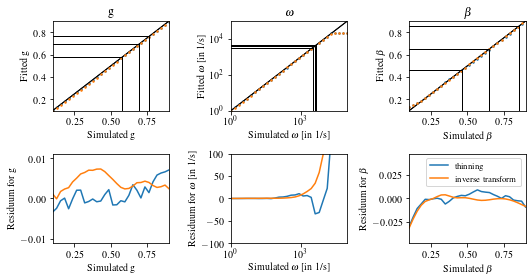

In [70]:
plt.rcParams["figure.figsize"] = (7.5,4)

fig, axs = plt.subplots(2,3)

for byitrans in [None, True]:
    default_g = .7
    default_omega = 3500
    default_beta = .45


    tbl = tl.dbconnect()
    tasks = list(
            tbl.aggregate([{"$match":{"status":3,"error":None,"task.origin.N":50000, 'task.origin.by_itrans':byitrans, 'task.task':"fit"}},{"$sort":{"task.id":1}}])
        )

    print(len(tasks))

    expected = []
    got = []

    for i in tasks:
        expected.append(i['task']['origin']['g_params'])
        got.append(i['result']['g_params'])

    modify_g = [(e,g) for g,e in zip(got, expected) if e[0] != default_g]
    modify_omega = [(e,g) for g,e in zip(got, expected) if e[1] != default_omega]
    modify_beta = [(e,g) for g,e in zip(got, expected) if e[2] != default_beta]
    print(len(modify_g),len(modify_omega),len(modify_beta))

    gmin = g_params.min(axis= 0)
    gmean = g_params.mean(axis= 0)
    gmax = g_params.max(axis= 0)

    g_space = np.linspace(.1,.9,30)
    omega = np.logspace(0,5,30)
    beta = np.linspace(.1,.9,30)
    
    
    
    qtymap = ['g',r'$\omega$',r'$\beta$']
    for trip in [(modify_g, g_space, lambda x:x, 0), (modify_omega, omega, lambda x:x, 1), (modify_beta, beta, lambda x:x, 2)]:
        
        
        f = trip[2]
        e,g = zip(*trip[0])
        

        idx = trip[3]
        qty = qtymap[idx]
        ax = axs[0][idx]
        ax.set_title(qty)
        ax.set_xlim([f(trip[1])[0],f(trip[1])[-1]])
        ax.set_ylim([f(trip[1])[0],f(trip[1])[-1]])
        
        pfunc = ax.plot if idx != 1 else ax.loglog
        
        pfunc(f(trip[1]),f(trip[1]),c='k',lw=1)

        pfunc([f(a[idx]) for a in e],[f(a[idx]) for a in g],'.',markersize=3,c=('tab:orange' if byitrans else 'tab:blue'))

        pfunc([0, f(gmin[idx]),f(gmin[idx])],[f(gmin[idx]),f(gmin[idx]),0],c='k',lw=1)
        pfunc([0, f(gmean[idx]),f(gmean[idx])],[f(gmean[idx]),f(gmean[idx]),0],c='k',lw=1)
        pfunc([0, f(gmax[idx]),f(gmax[idx])],[f(gmax[idx]),f(gmax[idx]),0],c='k',lw=1)
        unit = ' [in 1/s]' if qty == r'$\omega$' else ''
        ax.set_xlabel('Simulated '+qty+unit)
        ax.set_ylabel('Fitted '+qty+unit)
    
    
        #########
        ax = axs[1][idx]
        pfunc = ax.plot if idx != 1 else ax.semilogx
        ax.set_xlim([f(trip[1])[0],f(trip[1])[-1]])
        #ax.plot(f(trip[1]),f(trip[1]))

        pfunc([f(a[idx]) for a in e], [a[idx]-b[idx] for a,b in zip(e,g)], label=('inverse transform' if byitrans else 'thinning'))
        if idx == 1:
            ax.set_ylim([-100,100])
        else:
            q = np.abs( [a[idx]-b[idx] for a,b in zip(e,g)]).max()*1.52
            ax.set_ylim([-q,q])
        unit = ' [in 1/s]' if qty == r'$\omega$' else ''
        ax.set_xlabel('Simulated '+qty+unit)
        ax.set_ylabel('Residuum for '+qty+unit)
        if idx == 2:
            ax.legend(fontsize=9)
plt.tight_layout()
fig.savefig(folder+"res_lob56.pdf")

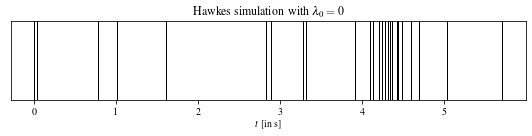

In [64]:
i = 7
c = np.array(candidates[i])
plt.rcParams["figure.figsize"] = (7.5,2)
fig, ax = plt.subplots()
ax.get_yaxis().set_visible(False)
for p in c:
    ax.plot([c,c],[0,1], lw=1, c='k')
ax.set_ylim([0,1])
ax.set_title('Hawkes simulation with $\lambda_0 = 0$')
ax.set_xlabel('$t$ [in s]')
plt.tight_layout()
fig.savefig(folder+"res_lob57.pdf")